# Converting from GeoDataFrame to Graph and back

The model situation expects to have all input data for analysis in `GeoDataFrames`, including street network (e.g. from shapefile).

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx

In [2]:
streets = gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")

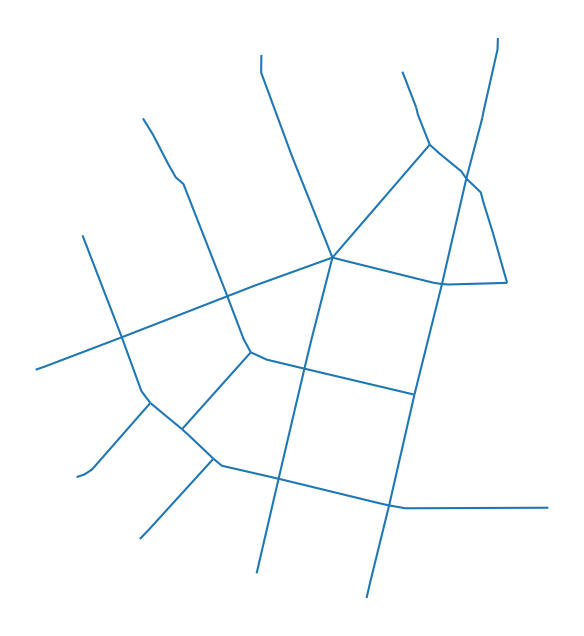

In [3]:
ax = streets.plot(figsize=(8, 8))
ax.set_axis_off()

We have to convert this LineString GeoDataFrame to a `networkx.Graph`. We use `momepy.gdf_to_nx` and later `momepy.nx_to_gdf` as a pair of interconnected functions. `gdf_to_nx` supports both primal and dual graphs. The primal approach will save the length of each segment to be used as a weight later, while dual will save the angle between segments (allowing angular centrality).

In [4]:
graph = momepy.gdf_to_nx(streets, approach="primal")

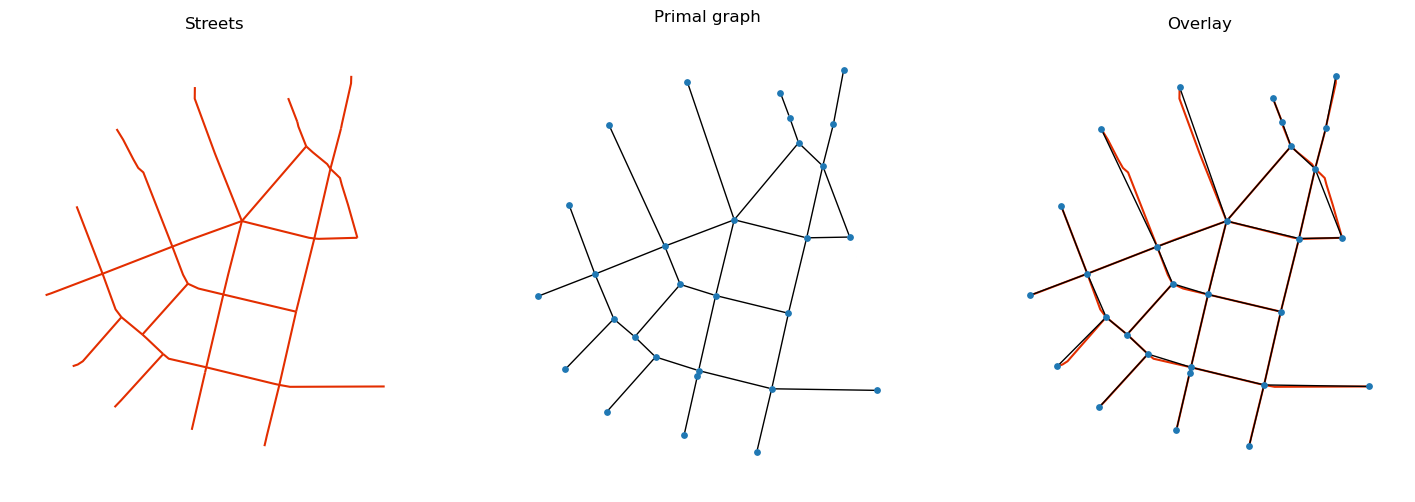

In [5]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
streets.plot(color="#e32e00", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(
    graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, ax=ax[1], node_size=15
)
streets.plot(color="#e32e00", ax=ax[2], zorder=-1)
nx.draw(
    graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, ax=ax[2], node_size=15
)

In [6]:
dual = momepy.gdf_to_nx(streets, approach="dual")

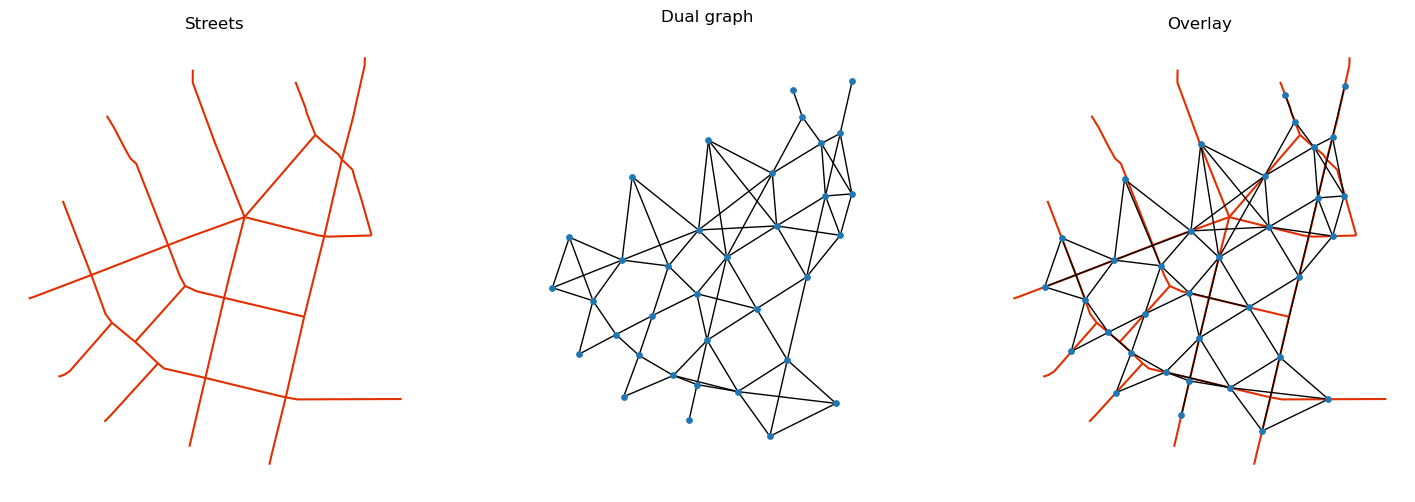

In [7]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
streets.plot(color="#e32e00", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Dual graph", "Overlay")[i])
    facet.axis("off")
nx.draw(
    dual, {n: [n[0], n[1]] for n in list(dual.nodes)}, ax=ax[1], node_size=15
)
streets.plot(color="#e32e00", ax=ax[2], zorder=-1)
nx.draw(
    dual, {n: [n[0], n[1]] for n in list(dual.nodes)}, ax=ax[2], node_size=15
)

At this moment (almost) any `networkx` method can be used. For illustration, we will measure the node degree. Using `networkx`, we can do:

In [8]:
degree = dict(nx.degree(graph))
nx.set_node_attributes(graph, degree, "degree")

However, node degree is implemented in momepy so we can use directly:

In [9]:
graph = momepy.node_degree(graph, name="degree")

Once we have finished our network-based analysis, we want to convert the graph back to a geodataframe. For that, we will use `momepy.nx_to_gdf`, which gives us several options of what to export.

- `lines`
    - original LineString geodataframe
- `points`
    - point geometry representing street network intersections (nodes of primal graph)
- `spatial_weights`
    - spatial weights for nodes capturing their relationship within a network

Moreover, `edges` will contain `node_start` and `node_end` columns capturing the ID of both nodes at its ends.

In [10]:
nodes, edges, sw = momepy.nx_to_gdf(
    graph, points=True, lines=True, spatial_weights=True
)

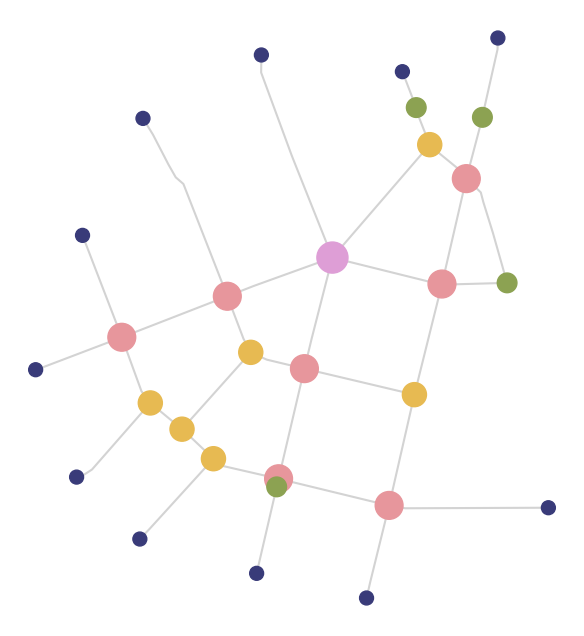

In [11]:
ax = nodes.plot(
    column="degree",
    cmap="tab20b",
    markersize=(nodes["degree"] * 100),
    zorder=2,
    figsize=(8, 8),
)
edges.plot(ax=ax, color="lightgrey", zorder=1)
ax.set_axis_off()

In [12]:
nodes.head(3)

,x,y,degree,nodeID,geometry
0,1.603586e+06,6.464429e+06,3,0,POINT (1603585.64 6464428.774)
1,1.603413e+06,6.464229e+06,5,1,POINT (1603413.206 6464228.73)
2,1.603269e+06,6.464061e+06,3,2,POINT (1603268.502 6464060.781)


In [13]:
edges.head(3)

,geometry,mm_len,node_start,node_end
0,"LINESTRING (1603585.64 6464428.774, 1603413.20...",264.103950,0,1
1,"LINESTRING (1603561.74 6464494.467, 1603564.63...",70.020202,0,8
2,"LINESTRING (1603585.64 6464428.774, 1603603.09...",88.924305,0,6


## Preserving the order and index

By default, the conversion to Graph and back does not preserve the index of the original GeoDataFrame and the order of rows. If you want to ensure that the roundtrip results in equally sorted GeoDataFrame with matching index, use `preserve_index=True`. This option adds one or two (depending on they type of the index) additional attributes to edges and uses them in conversion from Graph to rebuild the index and the order of rows.

See the default:

In [17]:
streets["position"] = range(len(streets))
streets.head()

,geometry,position
0,"LINESTRING (1603585.64 6464428.774, 1603413.20...",0
1,"LINESTRING (1603268.502 6464060.781, 1603296.8...",1
2,"LINESTRING (1603607.303 6464181.853, 1603592.8...",2
3,"LINESTRING (1603678.97 6464477.215, 1603675.68...",3
4,"LINESTRING (1603537.194 6464558.112, 1603557.6...",4


We have added a column tracking the original position. 

In [18]:
graph = momepy.gdf_to_nx(streets)
edges = momepy.nx_to_gdf(graph, points=False)
edges.head()

,geometry,position,mm_len
0,"LINESTRING (1603585.64 6464428.774, 1603413.20...",0,264.103950
1,"LINESTRING (1603561.74 6464494.467, 1603564.63...",14,70.020202
2,"LINESTRING (1603585.64 6464428.774, 1603603.09...",15,88.924305
3,"LINESTRING (1603607.303 6464181.853, 1603592.8...",2,199.746503
4,"LINESTRING (1603363.558 6464031.885, 1603376.5...",5,203.014090


Using `preserve_index=True` fixes the order and in case of a custom index rebuilds it.

In [19]:
graph = momepy.gdf_to_nx(streets, preserve_index=True)
edges = momepy.nx_to_gdf(graph, points=False)
edges.head()

,geometry,position,mm_len
0,"LINESTRING (1603585.64 6464428.774, 1603413.20...",0,264.103950
1,"LINESTRING (1603268.502 6464060.781, 1603296.8...",1,99.751190
2,"LINESTRING (1603607.303 6464181.853, 1603592.8...",2,199.746503
3,"LINESTRING (1603678.97 6464477.215, 1603675.68...",3,112.296576
4,"LINESTRING (1603537.194 6464558.112, 1603557.6...",4,68.214706
